# Inspect Breath Alignment: Pressure vs. Mask Particles

This notebook randomly samples 3-breath chunks from random files in the database and plots global pressure and mask particles for each chunk. Use these plots to visually inspect the alignment between pressure and particle data.

In [7]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

# Path to your database
DB_PATH = Path("../breath_db.sqlite") if not Path("breath_db.sqlite").exists() else Path("breath_db.sqlite")

conn = sqlite3.connect(DB_PATH)

In [8]:
# Get a list of all files with breath segments
files = pd.read_sql_query("SELECT DISTINCT source_file FROM breath_segments", conn)["source_file"].tolist()
print(f"Found {len(files)} files with breath segments.")

Found 59 files with breath segments.


In [9]:
# Randomly sample N files
N_FILES = min(5, len(files))
sampled_files = random.sample(files, N_FILES)
print("Randomly selected files:")
for f in sampled_files:
    print(f"  - {f}")

Randomly selected files:
  - rsc_P1_MAKTEK_frc_reset_20250609_112842_aligned.csv
  - rsc_P0_AURA_quiet_breathing_20250608_210154_aligned.csv
  - rsc_P3_HONEYWELL_leak_frc_reset_20250609_214307_aligned.csv
  - rsc_P0_MAKTEK_frc_reset_20250608_204845_aligned.csv
  - rsc_P4_HONEYWELL_frc_reset_20250610_133642_aligned.csv


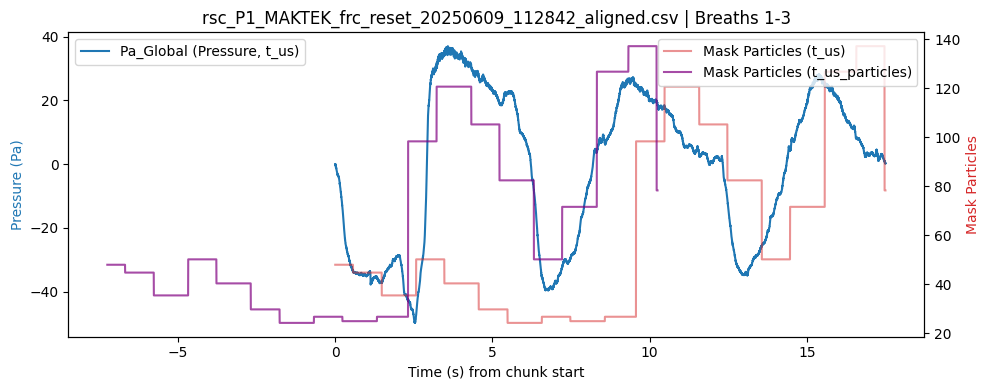

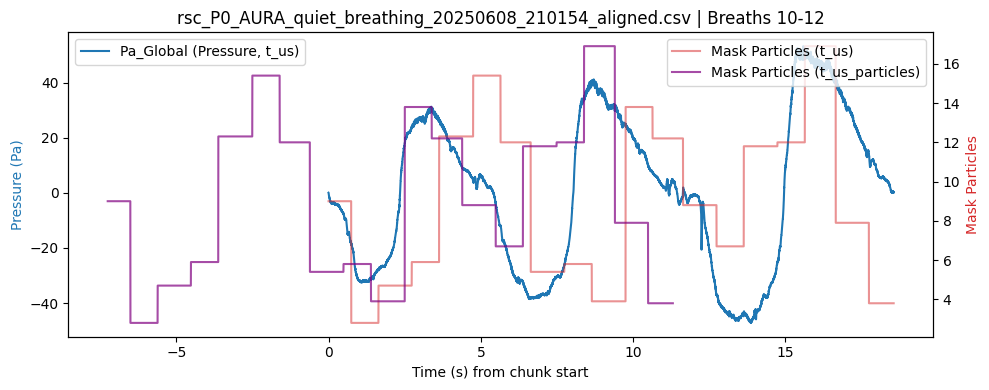

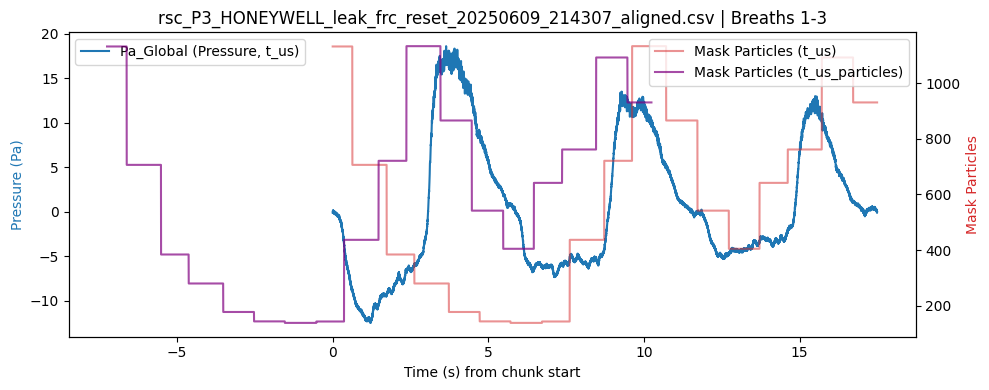

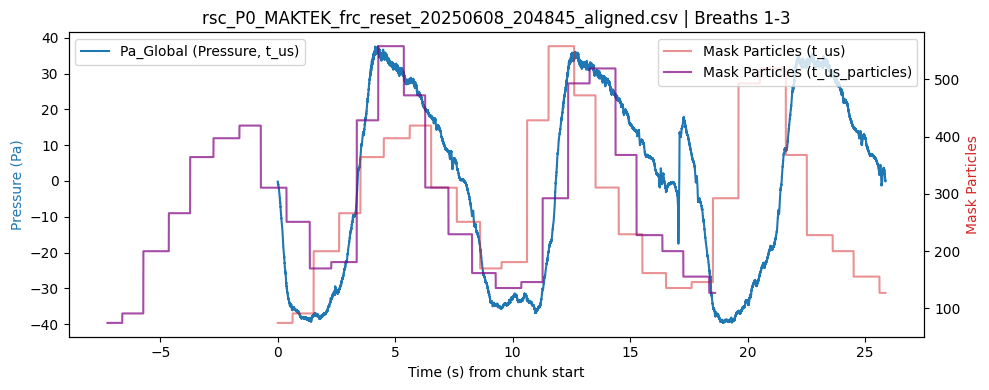

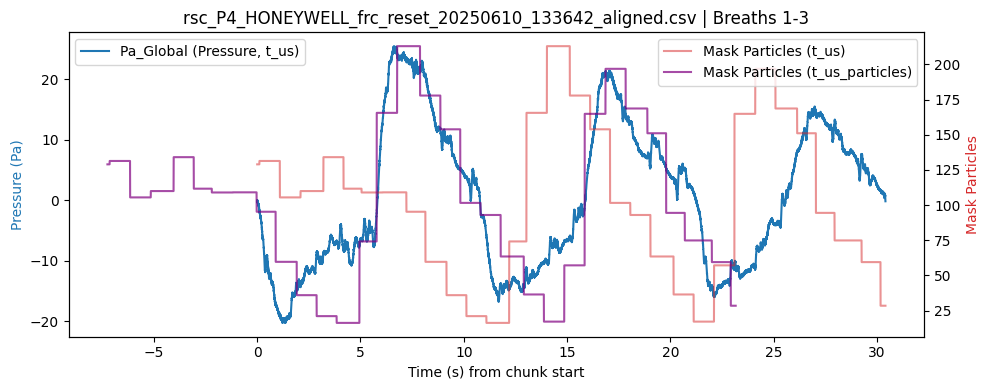

In [10]:
# For each file, randomly select a 3-breath chunk and plot
N_BREATHS = 3
for file in sampled_files:
    # Get all breath segments for this file
    segs = pd.read_sql_query(
        "SELECT breath, breath_start_us, breath_end_us FROM breath_segments WHERE source_file=? ORDER BY breath",
        conn, params=(file,)
    )
    if len(segs) < N_BREATHS:
        print(f"Skipping {file} (not enough breaths)")
        continue
    # Randomly select a starting index
    start_idx = random.randint(0, len(segs) - N_BREATHS)
    chunk = segs.iloc[start_idx:start_idx+N_BREATHS]
    start_us = chunk["breath_start_us"].iloc[0]
    end_us = chunk["breath_end_us"].iloc[-1]
    # Load breath_data for this interval, including t_us_particles if present
    df = pd.read_sql_query(
        "SELECT t_us, t_us_particles, Pa_Global, mask_particles FROM breath_data WHERE source_file=? AND t_us >= ? AND t_us < ?",
        conn, params=(file, int(start_us), int(end_us))
    )
    if df.empty:
        print(f"No data for {file} breaths {chunk['breath'].tolist()}")
        continue
    t = (df["t_us"] - df["t_us"].iloc[0]) * 1e-6  # seconds from chunk start
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(t, df["Pa_Global"], color="tab:blue", label="Pa_Global (Pressure, t_us)")
    # Plot mask_particles using original t_us
    ax2 = ax1.twinx()
    ax2.plot(t, df["mask_particles"], color="tab:red", label="Mask Particles (t_us)", alpha=0.5)
    # Plot mask_particles using t_us_particles if available
    if "t_us_particles" in df.columns and not df["t_us_particles"].isnull().all():
        t_particles = (df["t_us_particles"] - df["t_us"].iloc[0]) * 1e-6
        ax2.plot(t_particles, df["mask_particles"], color="purple", label="Mask Particles (t_us_particles)", alpha=0.7)
    ax1.set_xlabel("Time (s) from chunk start")
    ax1.set_ylabel("Pressure (Pa)", color="tab:blue")
    ax2.set_ylabel("Mask Particles", color="tab:red")
    ax1.set_title(f"{file} | Breaths {chunk['breath'].iloc[0]}-{chunk['breath'].iloc[-1]}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
conn.close()